In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
import time
from time import sleep
import os


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo


In [2]:
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mask = (~np.isnan(lofar['F_MIPS_24'])) 
lofar = lofar[~mask]
                                    

In [3]:
len(lofar)

10910

In [4]:
taskid = 40
batch_size = 20

if taskid*batch_size>len(lofar):
    print('Task id is too high. Trying to run code on more sources than exist')
    sys.exit()
ind_low = taskid*batch_size
if taskid*batch_size+batch_size>len(lofar):
    ind_up = len(lofar)-1
else:
    ind_up = taskid*batch_size+batch_size
ras = lofar['optRA'][ind_low:ind_up]
mask = np.isnan(ras)
ras[mask] = lofar['RA'][ind_low:ind_up][mask]

decs = lofar['optDec'][ind_low:ind_up]
mask = np.isnan(decs)
decs[mask] = lofar['DEC'][ind_low:ind_up][mask]

ids = lofar['Source_Name'][ind_low:ind_up]

In [55]:
source_use = [0,1,2,3,4,5,6,7,8,9]
ras = lofar['optRA'][source_use]
mask = np.isnan(ras)
ras[mask] = lofar['RA'][source_use][mask]

decs = lofar['optDec'][source_use]
mask = np.isnan(decs)
decs[mask] = lofar['DEC'][source_use][mask]

ids = lofar['Source_Name'][source_use]

In [5]:
len(ras)

20

In [6]:
#Read in the herschel images
imfolder='../../../../../HELP/dmu_products/dmu17/dmu17_HELP_Legacy_maps/Lockman-SWIRE/data/'

pswfits=imfolder+'wp4_lockman-swire_mips24_map_v1.0.fits.gz'#SPIRE 250 map

MIPS_Map = fits.open(pswfits)

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data #convert to mJy
nim250=hdulist[2].data #convert to mJy
w_250 = wcs.WCS(hdulist[1].header)
#pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

In [7]:
prior_cat = Table.read('data/data_release/xidplus_prior_cat_MIPS_rerun.fits')
MIPS_lower = prior_cat['MIPS_lower']
MIPS_upper = prior_cat['MIPS_upper']

In [8]:
len(prior_cat)

574869

In [9]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,20,15)

In [10]:
#---prior250--------
t1 = time.time()
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
t2 = time.time()
print('time taken is: {}s'.format(t2-t1))

#prior250=xidplus.prior(MIPS_Map[1].data,MIPS_Map[2].data,MIPS_Map[0].header,MIPS_Map[1].header,moc=moc)
prior250.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',flux_lower=MIPS_lower,flux_upper=MIPS_upper,ID=prior_cat['help_id'])#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

time taken is: 2286.830442905426s


In [10]:
#---prior250--------
t1 = time.time()
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
t2 = time.time()
print('time taken is: {}s'.format(t2-t1))

#prior250=xidplus.prior(MIPS_Map[1].data,MIPS_Map[2].data,MIPS_Map[0].header,MIPS_Map[1].header,moc=moc)
prior250.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',flux_lower=MIPS_lower,flux_upper=MIPS_upper,ID=prior_cat['help_id'])#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

time taken is: 736.1374473571777s


In [47]:
#for 1 source with 15" radius moc it took ~540s
#for 10 sources with 15" radius moc it took ~620s
#for 50 sources with 15" radius moc it took ~570s

In [48]:
MIPS_psf=fits.open(imfolder+'dmu17_MIPS_Lockman-SWIRE_20171122.fits')
centre=np.long((MIPS_psf[1].header['NAXIS1']-1)/2)
radius=20
prior250.set_prf(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/1.0E6,np.arange(0,41/2.0,0.5),np.arange(0,41/2.0,0.5))#requires PRF as 2d grid, and x and y bins for grid (in pixel scale)

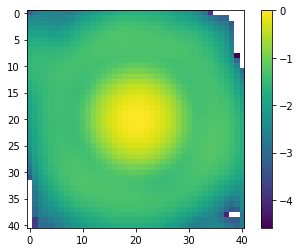

In [49]:
plt.imshow(np.log10(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/np.max(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1])))
plt.colorbar()

In [53]:
print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+' pixels')



fitting 185 sources 

using 23865 pixels


In [51]:
prior250.get_pointing_matrix()

In [61]:
from xidplus.stan_fit import MIPS,SPIRE
t1 = time.time()
fit=MIPS.MIPS_24(prior250,iter=1000)
t2 = time.time()
print('time taken is: {}s'.format(t2-t1))

/XID+MIPS found. Reusing
time taken is: 1080.5268867015839s


In [31]:
#50 sources took ~120s

In [62]:
posterior=xidplus.posterior_stan(fit,[prior250])

In [63]:
priors = [prior250]

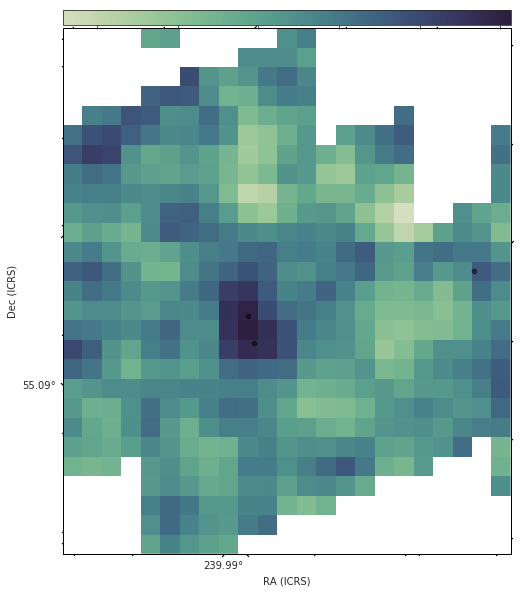

In [77]:
figs,fig=xidplus.plot_map(priors)

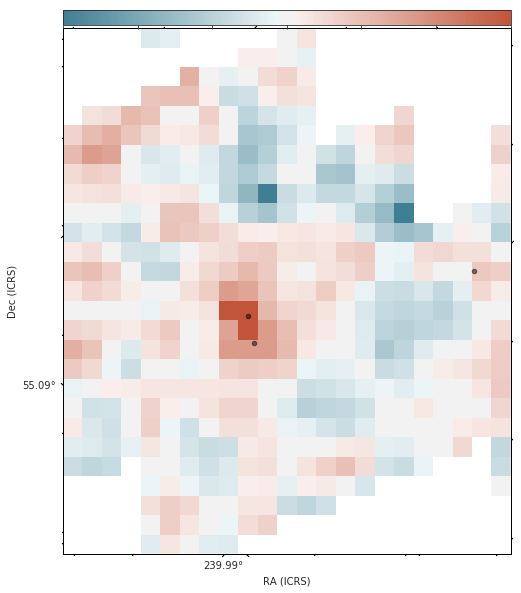

In [78]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)

In [64]:
import xidplus.catalogue as cat
MIPS_cat=cat.create_MIPS_cat(posterior,priors[0],0)

In [65]:
MIPS_cat = Table.read(MIPS_cat)

In [66]:
MIPS_cat

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J103919.007+585224.903,159.82919692870252,58.87358425985325,3.5636852,9.230397,0.8647562,-0.005068172,5.0111066e-06,0.9998194,3266.7603,0.0
HELP_J103919.115+585230.692,159.8296438707025,58.87519231185325,12.936922,25.799103,4.1452312,-0.005068172,5.0111066e-06,0.99986744,2572.4583,0.0
HELP_J103919.209+585240.188,159.83003691970248,58.877829987853254,7.5168557,17.931068,2.0021482,-0.005068172,5.0111066e-06,0.9999496,3067.3662,0.0
HELP_J103919.334+570153.573,159.83055656726384,57.03154798715799,152.21027,167.0526,136.68373,-0.005068172,5.0111066e-06,0.9994811,3563.7476,0.0
HELP_J103919.423+585656.650,159.8309305437025,58.94906935585325,1.8837569,4.9287467,0.5290869,-0.005068172,5.0111066e-06,0.99937016,2373.8225,0.0
HELP_J103919.511+575615.202,159.83129773540242,57.937556177890734,108.39916,124.704285,93.05699,-0.005068172,5.0111066e-06,0.99950486,2405.1248,0.0
HELP_J103919.662+591017.770,159.8319229667025,59.17160271985325,327.83685,343.27722,311.4406,-0.005068172,5.0111066e-06,0.999101,3275.253,0.0
HELP_J103919.914+573933.620,159.8329745867025,57.65933886385325,526.7061,556.3072,494.7363,-0.005068172,5.0111066e-06,0.9987706,2310.5059,0.0


In [ ]:
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_Lockman-SWIRE/data/Lockman-SWIRE_20180219.fits')

In [67]:
joined_mips = join(MIPS_cat,masterlist,join_type='inner',keys='help_id')

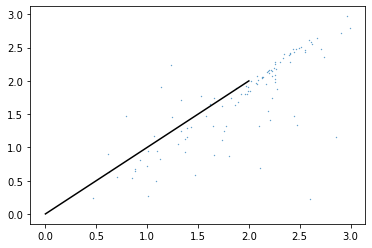

In [68]:
x = np.log10(joined_mips['f_mips_24'])
xerr = np.log10(joined_mips['ferr_mips_24'])
y = np.log10(joined_mips['F_MIPS_24'])
yerr_u = np.log10(joined_mips['FErr_MIPS_24_u'])
yerr_l = np.log10(joined_mips['FErr_MIPS_24_l'])

#plt.errorbar(x,y,xerr=xerr,yerr=[yerr_u,yerr_l])
plt.scatter(x,y,s=0.1)
plt.plot([0,2],[0,2],c='black')

plt.show()

In [67]:
mask = [MIPS_cat['help_id'][i] in ids for i in range(len(MIPS_cat))]
MIPS_cat[mask]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32
ILTJ155958.68+550534.6,239.9942929896559,55.0930282279941,90.73344,145.95277,30.674541,2.737582,4.8642487e-06,0.9985452,3958.191,0.0


In [140]:
mask = 'ILTJ' in SPIRE_cat['HELP_ID']
mask_lofar = lofar['ra']==ra
mask_pcat = prior_cat['help_id']=='lofar'
SPIRE_cat = SPIRE_cat[mask]
SPIRE_cat.add_columns([prior_cat['f_mips_24'][mask_pcat],prior_cat['flag_optnir_det'][mask_pcat]])
lofar_fir = hstack([lofar[mask_lofar],SPIRE_cat])
XID_rerun_col = Column(data=XID_rerun,name='XID_rerun',dtype=bool)
source_type_col = Column(data=source_type,name='source_type',dtype=str)
lofar_fir.add_columns([XID_rerun_col,source_type_col])
    
#os.mkdir('testfolder')
#Table.write(lofar_fir,'testfolder/lofar_xidplus_fir.fits')

In [141]:
lofar_fir

Source_id,Isl_id,RA_1,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,RA_max,E_RA_max,DEC_max,E_DEC_max,Maj,E_Maj,Min,E_Min,PA,E_PA,Maj_img_plane,E_Maj_img_plane,Min_img_plane,E_Min_img_plane,PA_img_plane,E_PA_img_plane,DC_Maj,E_DC_Maj,DC_Min,E_DC_Min,DC_PA,E_DC_PA,DC_Maj_img_plane,E_DC_Maj_img_plane,DC_Min_img_plane,E_DC_Min_img_plane,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,FLAG_OVERLAP_1,lr_fin,lr_dist_fin,lr_index_fin,fworkflow_all,FLAG_WORKFLOW,NUMBER,SNR_WIN,BACKGROUND,THRESHOLD,X_IMAGE,Y_IMAGE,ra,dec,X2_IMAGE,Y2_IMAGE,XY_IMAGE,X2_WORLD,Y2_WORLD,A_IMAGE,B_IMAGE,THETA_IMAGE,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,FLAGS_i,CLASS_STAR,FLAGS_J,FLAGS_K,FLAGS_g,FLAGS_hscg,FLAGS_hsci,FLAGS_hscnb921,FLAGS_hscr,FLAGS_hscy,FLAGS_hscz,FLAGS_r,FLAGS_se1,FLAGS_se2,FLAGS_sw1,FLAGS_sw2,FLAGS_sw3,FLAGS_sw4,FLAGS_u,FLAGS_y,FLAGS_z,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,MAG_APER_sw4_1,MAG_APER_sw4_2,MAG_APER_sw4_3,MAG_APER_sw4_4,MAG_APER_sw4_5,MAG_APER_sw4_6,MAG_APER_sw4_7,MAG_APER_sw4_10,MAGERR_APER_sw4_1,MAGERR_APER_sw4_2,MAGERR_APER_sw4_3,MAGERR_APER_sw4_4,MAGERR_APER_sw4_5,MAGERR_APER_sw4_6,MAGERR_APER_sw4_7,MAGERR_APER_sw4_10,FLUX_APER_sw4_1,FLUX_APER_sw4_2,FLUX_APER_sw4_3,FLUX_APER_sw4_4,FLUX_APER_sw4_5,FLUX_APER_sw4_6,FLUX_APER_sw4_7,FLUX_APER_sw4_10,FLUXERR_APER_sw4_1,FLUXERR_APER_sw4_2,FLUXERR_APER_sw4_3,FLUXERR_APER_sw4_4,FLUXERR_APER_sw4_5,FLUXERR_APER_sw4_6,FLUXERR_APER_sw4_7,FLUXERR_APER_sw4_10,MAG_APER_sw1_1,MAG_APER_sw1_2,MAG_APER_sw1_3,MAG_APER_sw1_4,MAG_APER_sw1_5,MAG_APER_sw1_6,MAG_APER_sw1_7,MAG_APER_sw1_10,MAGERR_APER_sw1_1,MAGERR_APER_sw1_2,MAGERR_APER_sw1_3,MAGERR_APER_sw1_4,MAGERR_APER_sw1_5,MAGERR_APER_sw1_6,MAGERR_APER_sw1_7,MAGERR_APER_sw1_10,FLUX_APER_sw1_1,FLUX_APER_sw1_2,FLUX_APER_sw1_3,FLUX_APER_sw1_4,FLUX_APER_sw1_5,FLUX_APER_sw1_6,FLUX_APER_sw1_7,FLUX_APER_sw1_10,FLUXERR_APER_sw1_1,FLUXERR_APER_sw1_2,FLUXERR_APER_sw1_3,FLUXERR_APER_sw1_4,FLUXERR_APER_sw1_5,FLUXERR_APER_sw1_6,FLUXERR_APER_sw1_7,FLUXERR_APER_sw1_10,MAG_APER_sw3_1,MAG_APER_sw3_2,MAG_APER_sw3_3,MAG_APER_sw3_4,MAG_APER_sw3_5,MAG_APER_sw3_6,MAG_APER_sw3_7,MAG_APER_sw3_10,MAGERR_APER_sw3_1,MAGERR_APER_sw3_2,MAGERR_APER_sw3_3,MAGERR_APER_sw3_4,MAGERR_APER_sw3_5,MAGERR_APER_sw3_6,MAGERR_APER_sw3_7,MAGERR_APER_sw3_10,FLUX_APER_sw3_1,FLUX_APER_sw3_2,FLUX_APER_sw3_3,FLUX_APER_sw3_4,FLUX_APER_sw3_5,FLUX_APER_sw3_6,FLUX_APER_sw3_7,FLUX_APER_sw3_10,FLUXERR_APER_sw3_1,FLUXERR_APER_sw3_2,FLUXERR_APER_sw3_3,FLUXERR_APER_sw3_4,FLUXERR_APER_sw3_5,FLUXERR_APER_sw3_6,FLUXERR_APER_sw3_7,FLUXERR_APER_sw3_10,MAG_APER_sw2_1,MAG_APER_sw2_2,MAG_APER_sw2_3,MAG_APER_sw2_4,MAG_APER_sw2_5,MAG_APER_sw2_6,MAG_APER_sw2_7,MAG_APER_sw2_10,MAGERR_APER_sw2_1,MAGERR_APER_sw2_2,MAGERR_APER_sw2_3,MAGERR_APER_sw2_4,MAGERR_APER_sw2_5,MAGERR_APER_sw2_6,MAGERR_APER_sw2_7,MAGERR_APER_sw2_10,FLUX_APER_sw2_1,FLUX_APER_sw2_2,FLUX_APER_sw2_3,FLUX_APER_sw2_4,FLUX_APER_sw2_5,FLUX_APER_sw2_6,FLUX_APER_sw2_7,FLUX_APER_sw2_10,FLUXERR_APER_sw2_1,FLUXERR_APER_sw2_2,FLUXERR_APER_sw2_3,FLUXERR_APER_sw2_4,FLUXERR_APER_sw2_5,FLUXERR_APER_sw2_6,FLUXERR_APER_sw2_7,FLUXERR_APER_sw2_10,MAG_APER_se2_1,MAG_APER_se2_2,MAG_APER_se2_3,MAG_APER_se2_4,MAG_APER_se2_5,MAG_APER_se2_6,MAG_APER_se2_7,MAG_APER_se2_10,MAGERR_APER_se2_1,MAGERR_APER_se2_2,MAGERR_APER_se2_3,MAGERR_APER_se2_4,MAGERR_APER_se2_5,MAGERR_APER_se2_6,MAGERR_APER_se2_7,MAGERR_APER_se2_10,FLUX_APER_se2_1,FLUX_APER_se2_2,FLUX_APER_se2_3,FLUX_APER_se2_4,FLUX_APER_se2_5,FLUX_APER_se2_6,FLUX_APER_se2_7,FLUX_APER_se2_10,FLUXERR_APER_se2_1,FLUXERR_APER_se2_2,FLUXERR_APER_se2_3,FLUXERR_APER_se2_4,FLUXERR_APER_se2_5,FLUXERR_APER_se2_6,FLUXERR_APER_se2_7,FLUXERR_APER_se2_10,MAG_APER_se1_1,MAG_APER_se1_2,MAG_APER_se1_3,MAG_APER_se1_4,MAG_APER_se1_5,MAG_APER_se1_6,MAG_APER_se1_7,MAG_APER_se1_10,MAGERR_APER_se1_1,MAGERR_APER_se1_2,MAGERR_APER_se1_3,MAGERR_APER_se1_4,MAGERR_APER_se1_5,MAGERR_APER_se1_6,MAGERR_APER_se1_7,MAGERR_APER_se1_10,FLUX_APER_se1_1,FLUX_APER_se1_2,FL

In [147]:
os.path.exists('data/fir_v2/xidplus_run_3')

True

In [9]:
len(lofar)

32833